In [24]:
%matplotlib inline 
from kf_book.gh_internal import plot_g_h_results
from kf_book.gh_internal import book_plots
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from numpy.random import randn
import numpy as np

# GHF状态估计滤波器（GHK-Filter）
---
这一节，主要介绍GHK-Filter的主要思想，也是Kalman-Filter的基本思想，可用下图来做解释说明。  
即：根据当前状态值所估计的下一状态的预估值，参考下一个状态的测量值，按照一定的置信度加权从而获得下一状态的实际估计值。  
其中，我们把$x_{t-1}$称作当前状态，把$\bar{x_t}$称作下一个状态的预估值，把$x_t$称作下一个状态的实际估计值。

In this section, I mainly introduce the main idea of GHK-Filter, which is also the basic idea of Kalman-Filter, which can be explained by the following figure.
That is, the estimated value of the next state according to the current state value, referring to the measured value of the next state, weighted according to a certain degree of confidence to obtain the actual estimated value of the next state.  
Where we call $x_{t-1}$ as the current state, $\bar{x_t}$ as the estimate of the next state, and $x_t$ as the actual estimate of the next state.

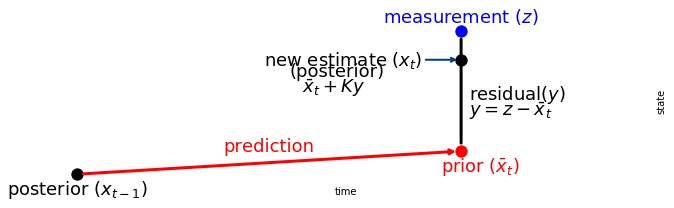

In [25]:
import kf_book.book_plots as book_plots
book_plots.show_residual_chart()

## 我们可以总结出一下几点(some important points)：
    1. 我们所需要的数据：
        - 当前状态的实际值与下一个状态的预估值
        - 下一个状态的实际测量值
        - 加权系数
    2. 如何预估下一状态：先验假设
    3. 如何分配预估值和测量值的加权比重：后验假设
    
    1. The data we need:
         - the actual value of the current state and the estimated value of the next state
         - Actual measured value of the next state
         - Weighting factor
    2. How to estimate the next state: a priori hypothesis
    3. How to assign the weighted weight of estimated and measured values: a posteriori hypothesis

## 1、数据(Data)
- ### 初始数据(initial data)

    不难想到，我们可以把任何一个需要估计的阶段的开始状态看作是状态零点，即：  
    It is not difficult to think that we can regard the start state of any phase that needs to be estimated as the state zero, ie:
$$ x= \left\lgroup \matrix{x \cr \dot x} \right\rgroup = \left\lgroup \matrix{0 \cr 0} \right\rgroup $$
    
    比如说：我们在使用手机上的记录跑步行程的软件的时候，我们总是可以选定开始的时间，开始的地点，也就是你开始使用的时间与地点，然后记录下来我们整个跑步行程。在这里我们的初始数据，就记为状态  
    For example, when we use the software on the mobile phone to record the running itinerary, we can always choose the starting time, the starting point, which is the time and place you started to use, and then record our entire running itinerary. Here our initial data is recorded as status
    $$x=0$$

    此外，我们还可以想到，初始状态为一个非零状态，他不一定是不变的，即：  
    In addition, we can also think of the initial state as a non-zero state, which is not necessarily constant, ie:
$$ x= \left\lgroup \matrix{x \cr \dot x} \right\rgroup = \left\lgroup \matrix{x_0 \cr \dot x_0} \right\rgroup $$

    比如说：一架歼-31战斗机从一艘某型号航空母舰上起飞，那么他起飞前就已经有了初始速度（即航空母舰相对于风的速度），而这些速度是我们可知的，那么我们就可以采用这样的一个初始状态来估计歼-31的离舰时候的速度。（*题外话，当然真实情况下不会采用这么简单的方式估计，至少是多模融合的*）  
    For example, if an F-35 fighter takes off from an aircraft carrier, then he has an initial speed before the takeoff (that is, the speed of the aircraft carrier relative to the wind), and this speed is known to us, then the initial state can be used to estimate the speed of the F-35 when it leaves the ship.

    再者，我们还可以想到，初始状态是无法确定的，这种情况也是比较常见的。因此，我们通常就取初始状态的测量值作为初始状态，即：  
    Furthermore, we can also think that the initial state is undetermined, and this situation is more common. Therefore, we usually take the measured value of the initial state as the initial state, ie:
$$ x= \left\lgroup \matrix{x \cr \dot x} \right\rgroup = \left\lgroup \matrix{z_0 \cr \dot z_0} \right\rgroup + random$$

- ### 测量数据(Measurement data)

    测量数据,就是我们传感器系统所输出的测量值。由于计算机擅长于离散数据的计算，所以状态估计滤波器通常接收到的测量信号都是离散信号。离散信号可以是，信号本身就是离散的，也可以是连续信号经过采样处理而离散化。比如说图像、数据库数据本身就是以离散信息形式储存的数据，这种数据我么可以直接拿来使用，再比如说，压力、温度等由物理信息直接转化为连续电信号的信息，就需要经过采样器获得离散信号再用于状态估计。  
    在本文中，由于是对理论的一种探讨，所以假设已经获得了离散测量信号，对采样过程感兴趣的朋友可以在大多数的信号处理的书籍文献中获取，应该说，滤波器是信号处理问题中的一部分内容，同时状态估计器和控制算法结合非常紧密，所以Dr.Kalman建立Kalman Filter标志现代控制理论的成熟。 
    
    The measured data is the measured value output by our sensor system. Since computers are good at the calculation of discrete data, the measurement signals normally received by the state estimation filter are discrete signals. In addition to the fact that the signal itself is discrete, the discrete signal can also be obtained by sampling the continuous signal. For example, images and database data are themselves stored in the form of discrete information. This data can be used directly by us. However, pressure, temperature, etc., which are directly converted from physical information into continuous electrical signals, require a sampler to obtain discrete signals for state estimation.  
    In this paper, because it is a discussion of theory, it is assumed that discrete measurement signals have been obtained, and friends interested in the sampling process can be obtained in most of the book literature on signal processing. It should be said that the filter is part of the signal processing problem, and the state estimator and the control algorithm are very tightly combined, so Dr. Kalman established the Kalman Filter to mark the maturity of modern control theory.

- ### 噪音 (Noise)
    噪声是普遍存在的物理现象，可以说但凡有测量的地方就一定有噪声的存在。状态估计滤波器的目的就是滤除噪音从而得到更加准确的估计值。通常情况下根据噪音的频谱图可以将噪音分为有色噪音和白色噪音。白色噪音被经常应用于状态估计中。  
    Noise is a ubiquitous physical phenomenon. It can be said that wherever there is a measurement, there must be noise. The purpose of the state estimation filter is to filter out noise to get a more accurate estimate. Noise is usually classified into colored noise and white noise based on the spectrogram of the noise. White noise is often used in state estimation.

接下来我们给一段白噪声的模型：  
Next we give a model of white noise:

In [ ]:
# 生成随机白噪声
x=[randn() for _ in range(3000)]
plt.plot(x,lw=1)

**[加性高斯白噪声](https://zh.wikipedia.org/zh-hans/加性高斯白噪声)**（英语：Additive white Gaussian noise，AWGN）在通信领域中指的是一种功率谱函数是常数（即[白噪声](https://www.wikiwand.com/zh-hans/%E7%99%BD%E9%9B%9C%E8%A8%8A)），且幅度服从高斯分布的噪声信号。因其可加性、幅度服从高斯分布且为白噪声的一种而得名。  
该噪声信号为一种便于分析的理想噪声信号，实际的噪声信号往往只在某一频段内可以用高斯白噪声的特性来进行近似处理。由于AWGN信号易于分析、近似，因此在信号处理领域，对信号处理系统（如滤波器、低噪音高频放大器、无线信号传输等）的噪声性能的简单分析(如：信噪比分析)中，一般可假设系统所产生的噪音或受到的噪音信号干扰在某频段或限制条件之下是高斯白噪声。  
加性高斯白噪声只是白噪声的一种，另有[泊松白噪声](http://www.jianshu.com/p/67f909f3d0ce)等。  

Additive white Gaussian noise refers to a noise signal whose power spectrum function is constant (ie white noise) and whose amplitude obeys a Gaussian distribution. He is named for his additivity, its magnitude, his Gaussian distribution, and his white noise.  
The noise signal is an ideal noise signal for analysis. The actual noise signal can be approximated by the characteristics of Gaussian white noise only in a certain frequency band. Since the AWGN signal is easy to analyze and approximate, in the field of signal processing, in the simple analysis of the noise performance of signal processing systems (such as filters, low-noise high-frequency amplifiers, wireless signal transmission, etc.) (such as signal-to-noise ratio analysis), It is generally assumed that the noise generated by the system or the noise signal received is Gaussian white noise under certain frequency bands or constraints.  
Additive white Gaussian noise is only one type of white noise, and Poisson white noise.

- ### 权系数 (weight coefficient)
     GHKFilter与KalmanFilter的主要区别就在于权系数的获得数学方法不同。GHKFilter的权系数是被假设为常值，分别是g、h、k三个参数，对应于广义位移、广义速度、广义加速度。因此，GHKFilter具有始终不变性，它的鲁棒性显得差一些。

     The main difference between GHKFilter and KalmanFilter is that the mathematical methods for obtaining the weight coefficients are different. The weight coefficient of GHKFilter is assumed to be a constant value, which is three parameters of g, h, and k, corresponding to generalized displacement, generalized velocity, and generalized acceleration. Therefore, GHKFilter is always invariant and its robustness is worse.

## 2、先验假设 (priori hypothesis)
   先验假设，就是由当前状态值根据物理模型估计下一个状态值。其估计方法为，在当前状态上加上含有不确定性的过程值，这个过程值通常就是在采样时间内发生的位移，即：  
   A priori hypothesis is that the current state value is used to estimate the next state value based on the physical model. The estimation method is to add a process value containing uncertainty to the current state, which is usually the displacement occurring during the sampling time, ie:
$$ x_{k+1}^{k}= x_{k}^{k} + \dot x_{k}^{k}dt + random$$

   状态不确定性，由当前状态不确定性和过程变化不确定性综合影响，具有线性累加性质。即：  
   State uncertainty, which is a combination of current state uncertainty and process variation uncertainty, has a linear additive nature.
$$ P_{k+1}^{k} = P_{k}^{k} + Q $$ 

   其中，`Q`是过程不确定，$x_{k}^{k}$是当前k时状态量，$P_{k}^{k}$是当前k时状态不确定，$x_{k+1}^{k}$是当前k时下一个状态的预估值  
   Where `Q` is the process uncertainty, $x_{k}^{k}$ is the current k state quantity, $P_{k}^{k}$ is the current k state uncertainty, $x_{k+ 1}^{k}$ is the estimated value of the next state at the current k

## 3、后验假设 (Posterior hypothesis)  
  后验假设，就是在先验假设的预估计值的基础上，参考测量值大小，选取一定的加权系数，从而修正预估值得到最终下一个状态的估计值。即：  
  A posterior hypothesis is based on the pre-estimated value of the priori hypothesis, with reference to the magnitude of the measured value, and a certain weighting coefficient is selected, thereby correcting the estimated value to obtain the estimated value of the final state.
$$ x_{k+1}^{k+1} = x_{k+1}^{k} + K(z_{k+1} - x_{k+1}^{k}) $$

$$ P_{k+1}^{k+1} = P_{k+1}^{k} - KHP_{k+1}^{k} $$

需要说明的是，此处`K`就是权系数，$x_{k+1}^{k+1}$是k时下一状态实际估计值， $P_{k+1}^{k+1}$是k时下一状态不确定性  
It should be noted that here `K` is the weight coefficient, $x_{k+1}^{k+1}$ is the actual estimated value of the next state when k, $P_{k+1}^{k+1} The next state uncertainty when $ is k

# 一个例子 (Example)：
   *本例中，为了简化，将加速度设为0，即只需GH两个参数*
   
   *In this example, for simplification, the acceleration is set to 0, that is, only two parameters of GH are required*

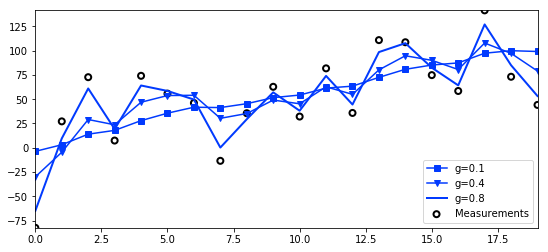

In [7]:
#定义GHfilter过程函数
def g_h_filter(data, x0, dx, g, h, dt=1.):
    x_est = x0
    results = []
    for z in data:
        #prediction step
        x_pred = x_est + (dx*dt)
        dx = dx

        # update step
        residual = z - x_pred
        dx = dx + h * (residual) / dt
        x_est = x_pred + g * residual     
        results.append(x_est)  
    return np.array(results)


#定义数据生成函数，实际上，这就是现实生活之中，传感器所测量得到的数据，由于存在白噪声，此处就拟合生成了一个存在白噪声的信号
def gene_data(x0, dx, count, noise_factor, accel=0.):
    z=[]
    for i in range(count):
        z.append(x0 + dx*i + randn()*noise_factor)
        dx += accel
    return np.array(z)


np.random.seed(100)



#获得数据的测量值数组，数据生成由：确信的初始位置x0、速度dx，过程加速度accel、位置噪音系数noise_factor。
measurements = gene_data(x0=5., dx=5., count=20, noise_factor=50, accel=0.) 

#获得三组不同GHfilter的估计值数组，数据生成由：测量值，确信的初始位置x0、速度dx，采样时间dt，以及滤波器性能参数 g、h
data1 = g_h_filter(data=measurements, x0=0., dx=5., dt=1., g=0.1, h=0.01)
data2 = g_h_filter(data=measurements, x0=0., dx=5., dt=1., g=0.4, h=0.01)
data3 = g_h_filter(data=measurements, x0=0., dx=5., dt=1., g=0.8, h=0.01)

#画图
with book_plots.figsize(y=4):
    book_plots.plot_measurements(measurements, lw=1, color='k')
    book_plots.plot_filter(data1, label='g=0.1', marker='s')
    book_plots.plot_filter(data2, label='g=0.4', marker='v')
    book_plots.plot_filter(data3, label='g=0.8', lw=2)
    plt.legend(loc=4)
    #book_plots.set_limits([20,40], [50, 250]) #g=0.2 and h=0.02, initial gusse for x to be 5
#plot_g_h_results(measurements, data)


*我们可以由图发现，当参数g不断增大的时候，滤波器更加偏向于相信测量值，而此时测量值的噪音相比于预估计较大，因此，g越大估计器的性能越不好。同
理，h也有类似的特性。*

*We can see from the graph that when the parameter g keeps increasing, the filter is more inclined to believe the measured value, and the noise of the measured value is larger than the pre-estimation. Therefore, the larger the g, the worse the performance of the estimator. Similarly, h has similar characteristics.*

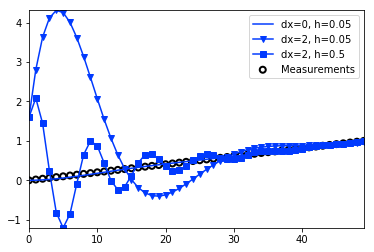

In [4]:
zs = np.linspace(0, 1, 50) # 假设一组测量无噪声的测量值

#对照分析不同参数的GHfilter有着怎么样的初始性能
data1 = g_h_filter(data=zs, x0=0, dx=0., dt=1., g=.2, h=0.05) #初速度为零，恰好与实际速度接近。虽速度修正系数h较小不能快速变化，也不碍整体性能
data2 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.05) #初速度远离于实际速度，速度修正系数h又小，速度难以修正到准确值，整体动态性能差
data3 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.5)  #初速度远离于实际速度，但速度修正系数h大，速度相比较快得到修正，整体动态性能向好

book_plots.plot_measurements(zs)
book_plots.plot_filter(data1, label='dx=0, h=0.05')
book_plots.plot_filter(data2, label='dx=2, h=0.05', marker='v')
book_plots.plot_filter(data3, label='dx=2, h=0.5',  marker='s')
plt.legend(loc=1);


In [30]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/7-JvyzOddTM?list=PL2Fyra_8f6uOliaoz0QBV4rdhfpqPvUGI" frameborder="0" allowfullscreen></iframe>')